## Read data

In [128]:
import pandas as pd

df = pd.read_csv('spotify-songs-preprocessed.csv')

df.head()

,artist_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,genre_rock,genre_r&b,genre_trap,genre_urban contemporary,genre_southern hip hop,genre_modern rock,genre_electro,genre_edm,genre_canadian pop,genre_house
0,71,0.853,0.606,0.0,66.0,1.0,0.0713,0.0561,0.000000,0.313,...,0,0,0,0,0,0,0,0,0,0
1,69,0.514,0.911,1.0,30.0,0.0,0.4100,0.0559,0.000000,0.775,...,0,1,0,1,0,0,0,0,0,0
2,88,0.780,0.768,6.0,63.0,0.0,0.2380,0.0371,0.000002,0.518,...,0,0,0,0,0,0,0,0,0,0
3,71,0.766,0.563,9.0,87.0,0.0,0.0339,0.0263,0.683000,0.115,...,0,0,0,0,0,0,0,0,0,0
4,75,0.754,0.811,5.0,56.0,1.0,0.0561,0.0185,0.000005,0.654,...,0,0,0,0,0,0,0,0,0,0


In [129]:
print ("Records and variables: ", df.shape)

Records and variables:  (2199, 30)


## Split data into train and test set

In [130]:
from sklearn.model_selection import train_test_split

y = df.pop('popular') # Target column
x = df

#split data into train and test set
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size=0.25,
    random_state=100,
    stratify=y
)

In [131]:
print("Train: ", x_train.shape, y_train.shape)
print("Test: ", x_test.shape, y_test.shape)

Train:  (1649, 29) (1649,)
Test:  (550, 29) (550,)


## Train the model

In [132]:
from sklearn.ensemble import RandomForestClassifier


baseRF = RandomForestClassifier(n_estimators = 200,  #The number of trees in the forest
                               random_state = 0,
                               n_jobs = -1, # The number of jobs to run in parallel (-1 means all processors, 1 no parallelism)
                               oob_score = True) # Whether to use out-of-bag samples to estimate the generalization score (increases time)
# oob are the samples not chosen on the boostrapping process

# other parameters:
# criterion{"gini", "entropy", "log_loss"}, default="gini"
# max_depth: int, default=None
# min_samples_leaf: int or float, default=1 - The minimum number of samples required to be at a leaf node
# min_samples_split: int or float, default=2 - The minimum number of samples required to split an internal node:
# max_features{"sqrt", "log2", None}, int or float, default="sqrt" - The number of features to consider when looking for the best split

In [133]:
param_grid = {
    'min_samples_leaf' :[3,5,7], 
    'criterion' : ['gini','entropy'],
    'max_features': ['sqrt', 'log2', 0.5, 0.7, 0.9],
    'n_estimators': [10, 50, 100, 200, 300]
}

In [134]:
import warnings

warnings.filterwarnings(
    "ignore",
    message="Some inputs do not have OOB scores",
    category=UserWarning,
    module="sklearn.ensemble._forest"
)

In [135]:
import time 
start_time = time.time()

from sklearn.model_selection import GridSearchCV
cvRF = GridSearchCV(estimator=baseRF, param_grid=param_grid, cv=3, scoring='roc_auc', verbose=0) 
#cv is the number of cross validation iterations to be performed
cvRF.fit(x_train, y_train)

print ("Completed in %s seconds" % (time.time() - start_time))

Completed in 56.55565404891968 seconds


In [136]:
# shows the best combination of criteria found
cvRF.best_params_

{'criterion': 'entropy',
 'max_features': 'sqrt',
 'min_samples_leaf': 5,
 'n_estimators': 200}

In [137]:
# shows the best score (of the scoring function we selected, here ROC AUC) from TRAINING DATASET
cvRF.best_score_

np.float64(0.7547554678839532)

## Get metrics

In [138]:
train_acc = round(cvRF.score(x_train, y_train) * 100,2) #Train Accuracy score
test_acc = round(cvRF.score(x_test, y_test) * 100,2) #Test Accuracy score
print("Train Accuracy score: ", train_acc, "%")
print("Test Accuracy score: ", test_acc, "%")

Train Accuracy score:  99.52 %
Test Accuracy score:  80.75 %


## Final Model performance

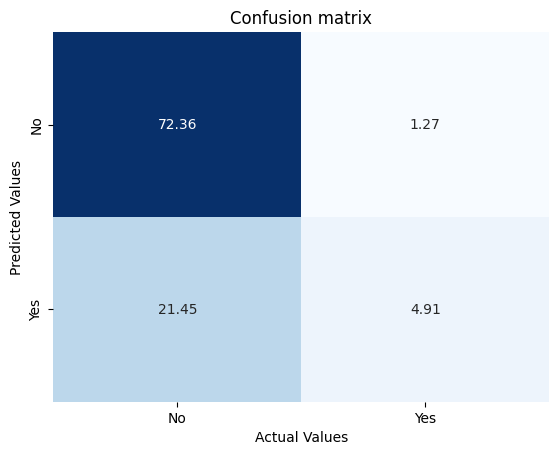

In [142]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

cutoff = 0.5

model = cvRF

prob_pred = model.predict_proba(x_test)[:, 1]
predictions_test = (prob_pred >= cutoff).astype(int)

test_conf_matrix = confusion_matrix(y_test, predictions_test)
test_conf_matrix_percentage = test_conf_matrix.astype('float') / test_conf_matrix.sum() * 100
test_conf_matrix_percentage = np.round(test_conf_matrix_percentage, 2) 
labels = ['No', 'Yes']

fig, ax = plt.subplots()
label_names = ['TN','FN','FP','TP']
label_counts = ['{0:0.0f}'.format(value) for value in test_conf_matrix_percentage.flatten()]

# Draw heatmap using confusion matrix
import seaborn as sns
sns.heatmap(test_conf_matrix_percentage, annot=True, fmt='.2f', cmap="Blues",
            xticklabels=labels, yticklabels=labels, cbar=False)

ax.set_title('Confusion matrix')
ax.set_xlabel('Actual Values')
ax.set_ylabel('Predicted Values');

Optimal Threshold: 0.30


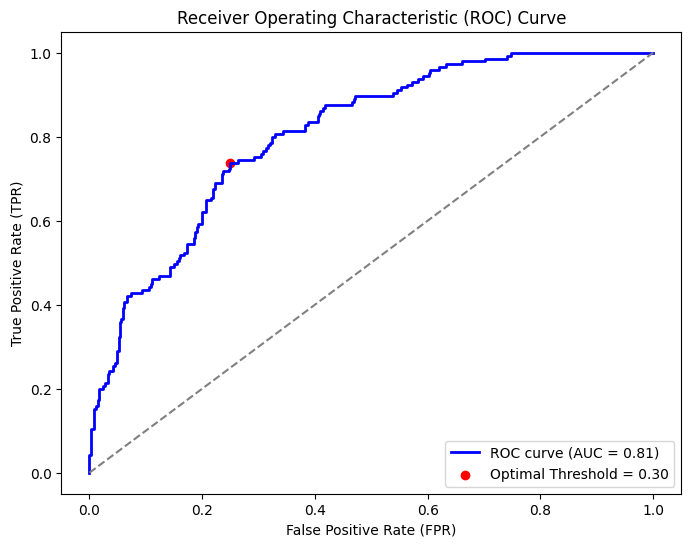

In [140]:
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, prob_pred)
roc_auc = auc(fpr, tpr)  
optimal_idx = np.argmax(tpr - fpr)  # Best trade-off between TPR and FPR
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold:.2f}")

# ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classification

# Highlight optimal threshold 
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', marker='o',
            label=f'Optimal Threshold = {optimal_threshold:.2f}')

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()